In [1]:
import sys; sys.path
import pandas as pd
import numpy as np 
import seaborn as sns
import scipy.io as sio
import os
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, StratifiedKFold
from sklearn import preprocessing, linear_model
from sklearn.metrics import explained_variance_score, r2_score, make_scorer
from sklearn.preprocessing import StandardScaler
from joblib import parallel_backend, Parallel, delayed
from prediction_functions4 import shiftedColorMap,prepare_image_data,prepare_data,np_pearson_cor,naive_pearson_cor,feature_select_PCA,feature_select_correlation,scale_data,normalize_data,gcv_ridge,gcv_ridge_strat,parallel_featsearch_strat,parallel_featsearch,gridsearch_cv_strat,gridsearch_cv,plot_figure


import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
data_dir = '/home/ubuntu/enigma/'
results_dir='/home/ubuntu/enigma/results/correlation_pairwiseSDC_shen268/'

df =  pd.read_csv(data_dir + 'Behaviour_Information_ALL_April7_2022.csv', header=0)
idx=np.isnan(df['NORMED_MOTOR'])

df=df[~idx]

site=df['SITE']

chronicity=df['CHRONICITY']

df_chronic=df[df['CHRONICITY']==180]
df_chronic=df_chronic.reset_index(drop=True)
ids=df_chronic['BIDS_ID']
ses=df_chronic['SES']
ids.to_csv(data_dir + '/chronic_ids.csv')

# Load SC pairwise (chronic)

# sub-r029s005 no MRI?
# sub-r052s034 no MRI?
# unpickle 
import pickle
import numpy as np
import scipy.io as sio
import os

sc= np.zeros([len(ids),35778])
nROIs=268

#chacoconn
for i in range(0,len(ids)):
    if i==293:
        continue
    if i==519:
        continue
    with open('/home/ubuntu/enigma/shen268/%s_ses-1_space-MNI152_desc-T1-lesion_mask_MNI_1mm_nemo_output_sdstream_chacoconn_shen268_mean.pkl'% (ids[i]), 'rb') as e:
        data = pickle.load(e)
        data= data.todense()
        sio.savemat('/home/ubuntu/enigma/shen268/%s_ses-1_space-MNI152_desc-T1-lesion_mask_MNI_1mm_nemo_output_sdstream_chacoconn_fs86subj_mean.mat'% (ids[i]), {'chacoconn':data})
    
    # pairwise vectorized upper triangular
    np.fill_diagonal(data, 0)
    sc[i,:] = data[np.triu_indices(nROIs,k=1)]

sc = np.delete(sc,(519), axis=0)   
sc = np.delete(sc,(293), axis=0)   

fuglmeyer=df_chronic['NORMED_MOTOR']

fuglmeyer.pop(519)
fuglmeyer.pop(293)
        

0.477272727

0.04412659043025463

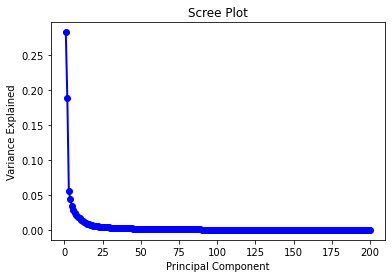

In [45]:
from sklearn.decomposition import PCA
sc.shape
pca = PCA(n_components = 200)

model = pca.fit(X)
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')

pca.explained_variance_ratio_[0]
pca.explained_variance_ratio_[3]

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
# principal components regression

train_size=0.8
X=np.array(sc)
X=prepare_data(X)

#set y to be the measure you want to predict
Y = np.array(fuglmeyer)
Y=np.reshape(Y, (627,1))

X, x_test, Y, y_test = train_test_split(X, Y, test_size=1-train_size, shuffle=True, random_state=1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0)

pcr = make_pipeline(StandardScaler(), PCA(n_components=5), LinearRegression())
pcr.fit(X_train, y_train)
pca = pcr.named_steps["pca"]  # retrieve the PCA step of the pipeline

pls = PLSRegression(n_components=5)
pls.fit(X_train, y_train)


print(f"PCR r-squared {pcr.score(X_test, y_test):.3f}")
print(f"PLS r-squared {pls.score(X_test, y_test):.3f}")

Final size of X: (627, 25057)
PCR r-squared 0.137
PLS r-squared 0.043


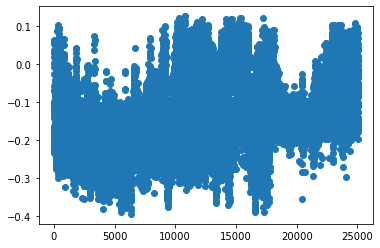

In [69]:
np_pearson_cor(X,Y).shape
plt.figsize=(10, 10)
plt.scatter(range(0,25057),np_pearson_cor(X,Y))

In [50]:

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].scatter(pca.transform(X_test), y_test, alpha=0.3, label="ground truth")
axes[0].scatter(
    pca.transform(X_test), pcr.predict(X_test), alpha=0.3, label="predictions"
)
axes[0].set(
    xlabel="Projected data onto first PCA component", ylabel="y", title="PCR / PCA"
)
axes[0].legend()
axes[1].scatter(pls.transform(X_test), y_test, alpha=0.3, label="ground truth")
axes[1].scatter(
    pls.transform(X_test), pls.predict(X_test), alpha=0.3, label="predictions"
)
axes[1].set(xlabel="Projected data onto first PLS component", ylabel="y", title="PLS")
axes[1].legend()
plt.tight_layout()
plt.show()

(126, 5)

In [40]:
y_test.shape

(101, 1)

Final size of X: (627, 25057)
5-fold cross-validation results in 400.8 subjects in the training set, and 100.2 subjects in the validation set
Best combination: 
 alpha =  204.33597178569437 
 Features =  18535 
 R^2 =  0.175


/home/ubuntu/enigma/prediction_functions4.py:105: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


0.11869275873216978


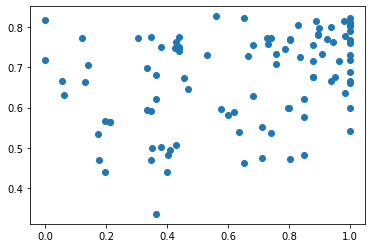

In [45]:
# -------------------- MODEL OPTIMIZATION --------------------
# range of alphas
n_alphas=30
alpha_start=-2
alpha_end=3
alphas = np.logspace(alpha_start, alpha_end, n_alphas, base=10,dtype=None)
p=0

#number of features (# pricipal components or variables to retain)
feat_start=2
feat_end=14.6129
n_feats=30
feats = np.logspace(feat_start, feat_end, n_feats,base=2, dtype=int)


#set the proportion of data you want in your training set
train_size = .8

#set the number of folds you want in the inner and outer folds of the nested cross-validation
k = 5
#set x data to be the input variable you want to use
#ie fc, sc, or hc
#X=np.concatenate([sc, fc], axis=1)
X=np.array(sc)
X=prepare_data(X)

#set y to be the measure you want to predict
Y = np.array(fuglmeyer)
Y=np.reshape(Y, (627,1))

featselect = 'correlation'

# set aside data for hold-out final testing: 
x, x_test, y, y_test = train_test_split(X, Y, test_size=1-train_size, shuffle=True, random_state=134)

bestalpha, bestfeats, bestr2, gcv_values_r2= gridsearch_cv(k, x, y, featselect, alphas, feats)

row=np.argmax(np.max(gcv_values_r2, axis=1))
col=np.argmax(np.max(gcv_values_r2, axis=0))
k = 5
bestalpha=alphas[row]
bestfeats=feats[col]

print('Best combination: \n alpha = ', str(alphas[row]), '\n Features = ', str(feats[col]), '\n R^2 = ', str(np.round(np.max(gcv_values_r2), 3)))

# initialize Ridge regression with alpha selected from hyperparameter search
regr = linear_model.Ridge(alpha=bestalpha, normalize=True, max_iter=1000000, random_state=p)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1-train_size, shuffle=True, random_state=121)

if featselect=='correlation':
    x_train_featselect,x_test_featureselect,ind = feature_select_correlation(x_train,x_test, y_train, bestfeats)

# initialize Ridge regression with alpha selected from hyperparameter search
regr = linear_model.Ridge(alpha=bestalpha, normalize=True, max_iter=1000000, random_state=p)

# fit model 
y_pred = regr.fit(x_train_featselect, y_train).predict(x_test_featureselect)

expl=explained_variance_score(y_test, y_pred)

print(expl)

plt.scatter(y_test, y_pred)


In [54]:
def plot_figure(gcv_values, string, midpoint):
    '''Plots the R^2 value obtained across all grid-search pairs (# features and regularization values.)
    
    Inputs:
        gcv_values - matrix to plot
        string - title
        midpoint - point at which blue turns to red.'''
    
    plt.figure(figsize=(17,14))
    shifted_cmap = shiftedColorMap(plt.get_cmap('bwr'), midpoint=midpoint, name='shifted')

    plt.imshow(gcv_values, cmap=shifted_cmap, interpolation='nearest')

    plt.xlabel('# Features', fontsize=15, fontweight='bold')
    plt.ylabel('Alphas', fontsize=15, fontweight='bold')

    row=np.argmax(np.max(gcv_values, axis=0))
    col=np.argmax(np.max(gcv_values, axis=1))

    ax = plt.axes()

    ax.xaxis.set_major_locator(plt.MultipleLocator(1))
    ax.yaxis.set_major_locator(plt.MultipleLocator(1))

    xticks= np.logspace(feat_start, feat_end,n_feats,base=2, dtype=int)
    yticks= np.logspace(alpha_start, alpha_end, n_alphas,base=10,dtype=None)

    plt.xticks(np.arange(len(feats)), fontsize=8)
    plt.yticks(np.arange(len(alphas)), fontsize=18)

    ax.set_xticklabels(xticks)
    ax.set_yticklabels(np.round(yticks,3))

    #ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{xticks: .2f}'))
    cbar = plt.colorbar()
    cbar.set_label('R^2')
    plt.title(string + '_Best R^2 = ' + str(np.round(np.max(gcv_values), 3)), fontsize=20)

    plt.scatter(row,col,color='k')
    #plt.savefig(results_dir+string+ '.png')
    #plt.show()



<ipython-input-54-675e955f8a17>:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


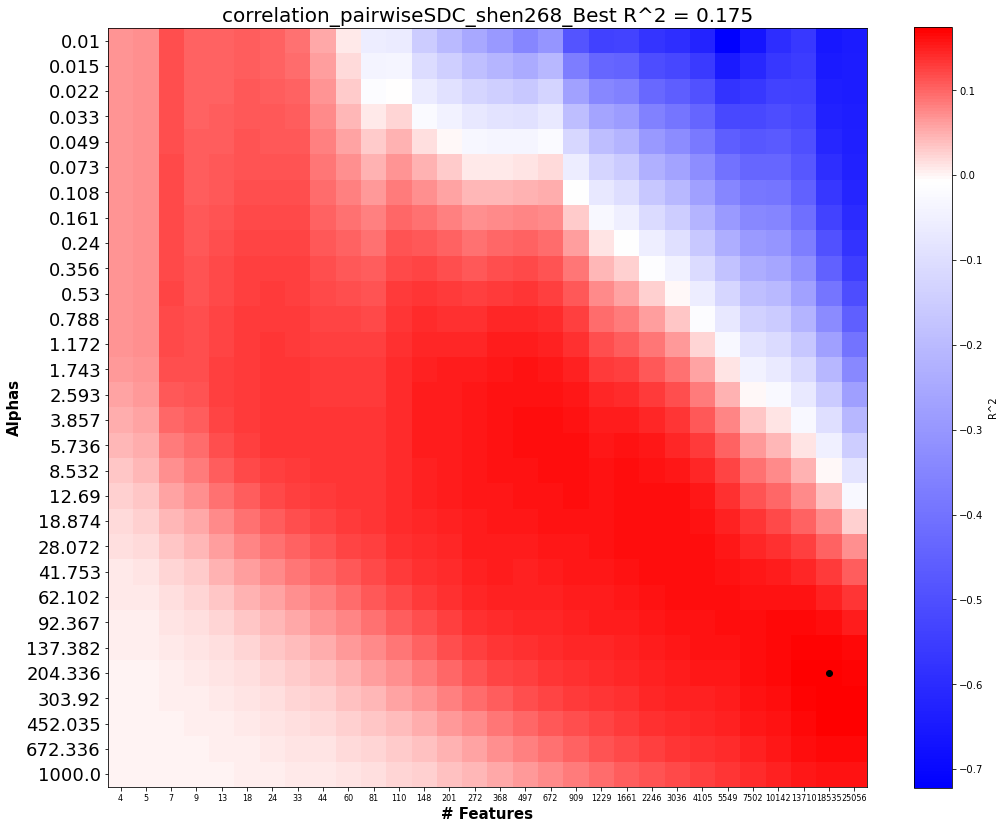

In [55]:
plot_figure(gcv_values_r2,'correlation_pairwiseSDC_shen268',0.80)

In [3]:
# predictions for SC-  PCA and correlation

import datetime
import pickle 

# feature selection type
f=['correlation']

for featselect in f: 
    #set the number of folds you want in the inner and outer folds of the nested cross-validation
    k = 5

    #set the proportion of data you want in your training set
    train_size = .8

    #X=np.concatenate([sc, fc], axis=1)
    X=sc
    X=prepare_data(X)
    #set y to be the measure you want to predict
    #Y = np.log(np.array(tmt))

    Y=np.array(fuglmeyer)
    Y=np.reshape(Y, (627,1))
    
    # range of alphas
    n_alphas=30
    alpha_start=-2
    alpha_end=3
    alphas = np.logspace(alpha_start, alpha_end, n_alphas, base=10, dtype=None)

    #number of features (# pricipal components or variables to retain)
    feat_start=2
    feat_end=14.6129
    n_feats=30
    feats = np.logspace(feat_start, feat_end, n_feats,base=2, dtype=int)

    # initialize lists to store model results for each permuation
    allR2=[]
    meanR2=[]
    features=[]
    bestalphas=[]
    importance=[]
    allexpl_var=[]
    correlations=[]
    chronic_allexpl_var=[]
    chronic_correlationr2_all=[]
    #joblib-based parallelism to increase speed,
    ytestc=[]
    ypredc=[]
    for p in range(89, 100):
        outer_cv = KFold(n_splits=k, shuffle=True, random_state=p)
        print('Permutation: ' + str(p))
        # initialize lists to store model results for eah fold
        R2=[]
        featur=[]
        best_alphas=[]
        impt=[] 
        expl_var=[]
        chronic_explvar=[]
        chronic_correlationr2=[]

        cor=[]
        for train, test in outer_cv.split(X):
            begin_time = datetime.datetime.now()
            
            
            # select model using training data
            bestalpha, bestfeats, bestr2, gcv_values = gridsearch_cv(k, X[train], Y[train], featselect, alphas, feats)

            # using optimal num. of features, select final features using entire training data.

            if featselect=='correlation':
                x_train_featselect,x_test_featureselect,ind = feature_select_correlation(X[train],X[test], Y[train], bestfeats)
                featur.append(ind)

            elif featselect=='PCA':
                x_train_featselect,x_test_featureselect,ind  = feature_select_PCA(X[train],X[test], bestfeats)
                featur.append(ind)
                
            # initialize Ridge regression with alpha selected from hyperparameter search
            regr = linear_model.Ridge(alpha=bestalpha, normalize=True, max_iter=1000000, random_state=p)

            # fit model 
            y_pred = regr.fit(x_train_featselect, Y[train]).predict(x_test_featureselect)

            # store results for each fold k
            impt.append(regr.coef_)
            expl_var.append(explained_variance_score(Y[test], y_pred))

            best_alphas.append(bestalpha)
            print('time to run loop: ' + str(datetime.datetime.now() - begin_time)) 
            print("Explained var: " + str(explained_variance_score(Y[test], y_pred)))
            print("correlation: " + str(np_pearson_cor(Y[test], y_pred)))
            
    
            cor.append(np_pearson_cor(Y[test], y_pred))
            Xtest=x_test_featureselect
            Xtrain=X[train]
            Ytest=Y[test]

        # store results for each permutation p

        allexpl_var.append(expl_var)
        bestalphas.append(best_alphas)
        importance.append(impt)
    
        print("---- Permutation avg. explained variance: " + str(np.mean(expl_var)) + "----")
        np.savetxt(results_dir + featselect + 'p' + str(p) + '_SC_all_explvar.txt', expl_var, delimiter=',')

        output = open(results_dir + featselect + 'p' + str(p) + '_SC_features.pkl', 'wb')
        pickle.dump(featur, output)
        output.close()
        
        output = open(results_dir + featselect + 'p' + str(p) + '_SC_correlations.pkl', 'wb')
        pickle.dump(correlations, output)
        output.close()

        output = open(results_dir + featselect + 'p' + str(p) + '_SC_bestalphas.pkl', 'wb')
        pickle.dump(best_alphas, output)
        output.close()
     
        output = open(results_dir + featselect + 'p' + str(p) + '_SC_varimpt.pkl', 'wb')
        pickle.dump(impt, output)
        output.close()   
        

Final size of X: (627, 25057)
Permutation: 89
5-fold cross-validation results in 400.8 subjects in the training set, and 100.2 subjects in the validation set
time to run loop: 0:01:45.931793
Explained var: 0.1155023761300712
correlation: [[0.35266729]]
5-fold cross-validation results in 400.8 subjects in the training set, and 100.2 subjects in the validation set
time to run loop: 0:01:44.494486
Explained var: 0.2526798169949309
correlation: [[0.50329216]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:01:45.228633
Explained var: 0.29539315361459084
correlation: [[0.54416599]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set


/home/ubuntu/enigma/prediction_functions4.py:105: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:01:44.673648
Explained var: 0.0750505991232181
correlation: [[0.32450677]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set


/home/ubuntu/enigma/prediction_functions4.py:105: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:01:44.635603
Explained var: 0.2989283417644554
correlation: [[0.55258035]]
---- Permutation avg. explained variance: 0.2075108575254533----
Permutation: 90
5-fold cross-validation results in 400.8 subjects in the training set, and 100.2 subjects in the validation set


/home/ubuntu/enigma/prediction_functions4.py:105: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:01:44.864951
Explained var: 0.28432842727299246
correlation: [[0.54070636]]
5-fold cross-validation results in 400.8 subjects in the training set, and 100.2 subjects in the validation set


/home/ubuntu/enigma/prediction_functions4.py:105: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:01:44.868697
Explained var: 0.2863889256804092
correlation: [[0.54118088]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:01:45.471015
Explained var: 0.11962088160929207
correlation: [[0.3505992]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set


/home/ubuntu/enigma/prediction_functions4.py:105: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:01:44.893381
Explained var: 0.16493726876851578
correlation: [[0.41345445]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:01:45.165443
Explained var: 0.16953565035576923
correlation: [[0.42141685]]
---- Permutation avg. explained variance: 0.20496223073739578----
Permutation: 91
5-fold cross-validation results in 400.8 subjects in the training set, and 100.2 subjects in the validation set


/home/ubuntu/enigma/prediction_functions4.py:105: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:01:44.855691
Explained var: 0.17166094455297642
correlation: [[0.43213107]]
5-fold cross-validation results in 400.8 subjects in the training set, and 100.2 subjects in the validation set


/home/ubuntu/enigma/prediction_functions4.py:105: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:01:44.388794
Explained var: 0.13035202878228314
correlation: [[0.37830505]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:01:44.216783
Explained var: 0.24443439273555445
correlation: [[0.50167451]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set


/home/ubuntu/enigma/prediction_functions4.py:105: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:01:45.295769
Explained var: 0.2661116263415213
correlation: [[0.52423249]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:01:44.716813
Explained var: 0.1907393379434904
correlation: [[0.44699104]]
---- Permutation avg. explained variance: 0.20065966607116517----
Permutation: 92
5-fold cross-validation results in 400.8 subjects in the training set, and 100.2 subjects in the validation set
time to run loop: 0:01:44.016445
Explained var: 0.09890477642817574
correlation: [[0.36277996]]
5-fold cross-validation results in 400.8 subjects in the training set, and 100.2 subjects in the validation set
time to run loop: 0:01:44.301563
Explained var: 0.28830263560760616
correlation: [[0.53926316]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set


/home/ubuntu/enigma/prediction_functions4.py:105: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:01:44.338291
Explained var: 0.16591668378101432
correlation: [[0.40807503]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set


/home/ubuntu/enigma/prediction_functions4.py:105: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:01:44.978483
Explained var: 0.22360697573448574
correlation: [[0.47341903]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set


/home/ubuntu/enigma/prediction_functions4.py:105: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:01:45.554742
Explained var: 0.1850313158245117
correlation: [[0.43313751]]
---- Permutation avg. explained variance: 0.19235247747515874----
Permutation: 93
5-fold cross-validation results in 400.8 subjects in the training set, and 100.2 subjects in the validation set


/home/ubuntu/enigma/prediction_functions4.py:105: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:01:44.807446
Explained var: 0.2168832860164137
correlation: [[0.46592458]]
5-fold cross-validation results in 400.8 subjects in the training set, and 100.2 subjects in the validation set
time to run loop: 0:01:44.252104
Explained var: 0.2393803538182856
correlation: [[0.50146824]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:01:45.014301
Explained var: -0.05925273953453902
correlation: [[0.2326596]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:01:45.293633
Explained var: 0.2506495973640994
correlation: [[0.50122865]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set


/home/ubuntu/enigma/prediction_functions4.py:105: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:01:44.880882
Explained var: 0.19580237498291375
correlation: [[0.45619372]]
---- Permutation avg. explained variance: 0.1686925745294347----
Permutation: 94
5-fold cross-validation results in 400.8 subjects in the training set, and 100.2 subjects in the validation set


/home/ubuntu/enigma/prediction_functions4.py:105: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:01:45.293059
Explained var: 0.13712934232695606
correlation: [[0.37652321]]
5-fold cross-validation results in 400.8 subjects in the training set, and 100.2 subjects in the validation set
time to run loop: 0:01:44.781212
Explained var: 0.23726737307981827
correlation: [[0.50342903]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set


/home/ubuntu/enigma/prediction_functions4.py:105: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:01:46.317009
Explained var: 0.24223728041936055
correlation: [[0.49635728]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set


/home/ubuntu/enigma/prediction_functions4.py:105: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:01:48.006481
Explained var: 0.20824967802951244
correlation: [[0.463083]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set


/home/ubuntu/enigma/prediction_functions4.py:105: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:01:48.830860
Explained var: 0.2260236122910353
correlation: [[0.4827003]]
---- Permutation avg. explained variance: 0.2101814572293365----
Permutation: 95
5-fold cross-validation results in 400.8 subjects in the training set, and 100.2 subjects in the validation set


/home/ubuntu/enigma/prediction_functions4.py:105: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:01:46.753507
Explained var: 0.17682330122495993
correlation: [[0.44299399]]
5-fold cross-validation results in 400.8 subjects in the training set, and 100.2 subjects in the validation set
time to run loop: 0:01:44.713659
Explained var: 0.10948120406510042
correlation: [[0.34468036]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set


/home/ubuntu/enigma/prediction_functions4.py:105: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:01:44.901422
Explained var: 0.24603585490742508
correlation: [[0.4992948]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set


/home/ubuntu/enigma/prediction_functions4.py:105: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:01:45.156299
Explained var: 0.24408698206842738
correlation: [[0.50215274]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:01:44.085001
Explained var: 0.1627698925089316
correlation: [[0.40445614]]
---- Permutation avg. explained variance: 0.18783944695496888----
Permutation: 96
5-fold cross-validation results in 400.8 subjects in the training set, and 100.2 subjects in the validation set


/home/ubuntu/enigma/prediction_functions4.py:105: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:01:44.283732
Explained var: 0.28281054136976924
correlation: [[0.54859061]]
5-fold cross-validation results in 400.8 subjects in the training set, and 100.2 subjects in the validation set


/home/ubuntu/enigma/prediction_functions4.py:105: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:01:44.211959
Explained var: 0.1386980811171601
correlation: [[0.39366536]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set


/home/ubuntu/enigma/prediction_functions4.py:105: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:01:44.359569
Explained var: 0.13867498788721766
correlation: [[0.40467962]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set


/home/ubuntu/enigma/prediction_functions4.py:105: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:01:45.262246
Explained var: 0.15289441813212234
correlation: [[0.39104862]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:01:44.482616
Explained var: 0.0778141404935696
correlation: [[0.33626372]]
---- Permutation avg. explained variance: 0.1581784337999678----
Permutation: 97
5-fold cross-validation results in 400.8 subjects in the training set, and 100.2 subjects in the validation set


/home/ubuntu/enigma/prediction_functions4.py:105: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:01:43.653147
Explained var: 0.2789591925965992
correlation: [[0.53216504]]
5-fold cross-validation results in 400.8 subjects in the training set, and 100.2 subjects in the validation set
time to run loop: 0:01:43.777220
Explained var: 0.2622722361289893
correlation: [[0.52461729]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:01:44.117213
Explained var: 0.20969411982598707
correlation: [[0.4614202]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:01:44.077941
Explained var: 0.15217436383276806
correlation: [[0.39913835]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set


/home/ubuntu/enigma/prediction_functions4.py:105: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:01:44.980760
Explained var: 0.11930849541503141
correlation: [[0.36435829]]
---- Permutation avg. explained variance: 0.20448168155987503----
Permutation: 98
5-fold cross-validation results in 400.8 subjects in the training set, and 100.2 subjects in the validation set


/home/ubuntu/enigma/prediction_functions4.py:105: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:01:44.666611
Explained var: 0.10982842937625248
correlation: [[0.35486247]]
5-fold cross-validation results in 400.8 subjects in the training set, and 100.2 subjects in the validation set


/home/ubuntu/enigma/prediction_functions4.py:105: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:01:43.868048
Explained var: 0.177165580962384
correlation: [[0.42145487]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set


/home/ubuntu/enigma/prediction_functions4.py:105: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:01:45.597726
Explained var: 0.22633623211357545
correlation: [[0.47713295]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set


/home/ubuntu/enigma/prediction_functions4.py:105: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:01:45.380695
Explained var: 0.19025484809126703
correlation: [[0.4362483]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:01:44.262283
Explained var: 0.2878735324738966
correlation: [[0.55907821]]
---- Permutation avg. explained variance: 0.1982917246034751----
Permutation: 99
5-fold cross-validation results in 400.8 subjects in the training set, and 100.2 subjects in the validation set


/home/ubuntu/enigma/prediction_functions4.py:105: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:01:44.549539
Explained var: 0.1792265560696914
correlation: [[0.45956312]]
5-fold cross-validation results in 400.8 subjects in the training set, and 100.2 subjects in the validation set


/home/ubuntu/enigma/prediction_functions4.py:105: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:01:44.570097
Explained var: 0.2767203022334208
correlation: [[0.53049279]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:01:44.651253
Explained var: 0.24603772645251076
correlation: [[0.50131446]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set
time to run loop: 0:01:45.310401
Explained var: 0.02858914504842247
correlation: [[0.25464311]]
5-fold cross-validation results in 401.6 subjects in the training set, and 100.4 subjects in the validation set


/home/ubuntu/enigma/prediction_functions4.py:105: RuntimeWarning: invalid value encountered in true_divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


time to run loop: 0:01:44.846970
Explained var: 0.21841398232212428
correlation: [[0.4673557]]
---- Permutation avg. explained variance: 0.18979754242523394----


In [8]:
# Haufe transformation of feature weights
k=5
Y = np.array(fuglmeyer)

# load activation weights
with open(results_dir + 'correlation' + 'p99_SC_varimpt.pkl', 'rb') as f:
    activ = pickle.load(f)
    
    
perm=0
fullactivations=[] 
#iterate through permutations
for p in range(0,100):
    # load activation weights
    with open(results_dir + 'correlation' + 'p' + str(p) + '_SC_varimpt.pkl', 'rb') as f:
        activ = pickle.load(f)
        
    k=5
    outer_cv = KFold(n_splits=k, shuffle=True, random_state=p)
    
    # Load features selected from permutation
    with open(results_dir + 'correlation' + 'p' + str(p) + '_SC_features.pkl', 'rb') as f:
        feats = pickle.load(f)
    
    c=0   
    activations=[]
    X=sc
    X=prepare_data(X)
    fullactivation=[]
    activationweight=[]
    for train, test in outer_cv.split(X,Y):
        x_train=X[train]
        X=x_train
        X_sub=X[:,feats[c][:]]
        
        print(X_sub.shape)
        
        X_sub=np.reshape(X_sub, [len(train),feats[c].shape[0]])
        cov_x=np.cov(np.transpose(X_sub))
        print('covx;')
        print(cov_x.shape)
        print(feats[c].shape[0])
        
        if feats[c].shape[0]==1:
            cov_x=np.reshape(cov_x, [1,1])
        
        cov_y=np.cov(np.transpose(Y[train]))
        
        activationweight=activ[c]
        
        
        activationweight=activationweight[0]# remove binary chronicity variable
        
        weight=np.transpose(activationweight)

        activation=np.matmul(cov_x,weight)*(1/cov_y)
        activations.append(activation)
        #print(activation.shape)

        # get activation weights back to matrix form 86x86
        # get indices of weights not selected as features; set weight to 0    
        idx=np.ones(shape=(25057,1), dtype='bool')
        idx[feats[c]]=False # set SC weights that are features to be 1
        idx=idx.flatten()
        zeroidx=np.arange(0, 25057, dtype='int')
        zeroidx=zeroidx[idx]
        
        # fill spots with 0's (up to 3192)
        k=0
        activation_full = activation
        while k < zeroidx.shape[0]:
            activation_full=np.insert(activation_full, zeroidx[k],0)
            k=k+1
        
        #print("Full 3192: " + str(np.sum(activation_full>0)))
        # fill spots with 0's (up to 3655)
        X=sc
        zeros=sc==0
        zeros=np.sum(zeros,0) # number of zeros across subjects
        zeros=zeros==X.shape[0] # find columns with zeros for all 101 subjects
        X=X[:,~zeros]
        
        zeroidx=np.arange(0, 35778)
        zeroidx=zeroidx[zeros]

        # fill spots with 0's
        k=0
        a = activation_full
        while k < zeroidx.shape[0]:
            a=np.insert(a, zeroidx[k],0)
            k=k+1
        
        #print("Full 3655: " + str(np.sum(a>0)))
        fullactivation.append(a)
        c=c+1
         
    fullactivations.append(fullactivation)

Final size of X: (627, 25057)
(501, 672, 1)
covx;
(672, 672)
672
(501, 13710, 1)
covx;
(13710, 13710)
13710
(502, 148, 1)
covx;
(148, 148)
148
(502, 25056, 1)
covx;
(25056, 25056)
25056
(502, 1229, 1)
covx;
(1229, 1229)
1229
Final size of X: (627, 25057)
(501, 3036, 1)
covx;
(3036, 3036)
3036
(501, 497, 1)
covx;
(497, 497)
497
(502, 13710, 1)
covx;
(13710, 13710)
13710
(502, 25056, 1)
covx;
(25056, 25056)
25056
(502, 18535, 1)
covx;
(18535, 18535)
18535
Final size of X: (627, 25057)
(501, 1229, 1)
covx;
(1229, 1229)
1229
(501, 672, 1)
covx;
(672, 672)
672
(502, 368, 1)
covx;
(368, 368)
368
(502, 1229, 1)
covx;
(1229, 1229)
1229
(502, 368, 1)
covx;
(368, 368)
368
Final size of X: (627, 25057)
(501, 672, 1)
covx;
(672, 672)
672
(501, 25056, 1)
covx;
(25056, 25056)
25056
(502, 18535, 1)
covx;
(18535, 18535)
18535
(502, 909, 1)
covx;
(909, 909)
909
(502, 1661, 1)
covx;
(1661, 1661)
1661
Final size of X: (627, 25057)
(501, 1661, 1)
covx;
(1661, 1661)
1661
(501, 25056, 1)
covx;
(25056, 25056

(502, 18535, 1)
covx;
(18535, 18535)
18535
Final size of X: (627, 25057)
(501, 13710, 1)
covx;
(13710, 13710)
13710
(501, 18535, 1)
covx;
(18535, 18535)
18535
(502, 13710, 1)
covx;
(13710, 13710)
13710
(502, 672, 1)
covx;
(672, 672)
672
(502, 18535, 1)
covx;
(18535, 18535)
18535
Final size of X: (627, 25057)
(501, 25056, 1)
covx;
(25056, 25056)
25056
(501, 13710, 1)
covx;
(13710, 13710)
13710
(502, 13710, 1)
covx;
(13710, 13710)
13710
(502, 13710, 1)
covx;
(13710, 13710)
13710
(502, 2246, 1)
covx;
(2246, 2246)
2246
Final size of X: (627, 25057)
(501, 497, 1)
covx;
(497, 497)
497
(501, 25056, 1)
covx;
(25056, 25056)
25056
(502, 10142, 1)
covx;
(10142, 10142)
10142
(502, 110, 1)
covx;
(110, 110)
110
(502, 13710, 1)
covx;
(13710, 13710)
13710
Final size of X: (627, 25057)
(501, 18535, 1)
covx;
(18535, 18535)
18535
(501, 1229, 1)
covx;
(1229, 1229)
1229
(502, 13710, 1)
covx;
(13710, 13710)
13710
(502, 13710, 1)
covx;
(13710, 13710)
13710
(502, 13710, 1)
covx;
(13710, 13710)
13710
Final siz

(502, 25056, 1)
covx;
(25056, 25056)
25056
(502, 272, 1)
covx;
(272, 272)
272
(502, 18535, 1)
covx;
(18535, 18535)
18535
Final size of X: (627, 25057)
(501, 909, 1)
covx;
(909, 909)
909
(501, 13710, 1)
covx;
(13710, 13710)
13710
(502, 13710, 1)
covx;
(13710, 13710)
13710
(502, 1229, 1)
covx;
(1229, 1229)
1229
(502, 13710, 1)
covx;
(13710, 13710)
13710
Final size of X: (627, 25057)
(501, 25056, 1)
covx;
(25056, 25056)
25056
(501, 672, 1)
covx;
(672, 672)
672
(502, 13710, 1)
covx;
(13710, 13710)
13710
(502, 13710, 1)
covx;
(13710, 13710)
13710
(502, 672, 1)
covx;
(672, 672)
672
Final size of X: (627, 25057)
(501, 272, 1)
covx;
(272, 272)
272
(501, 1229, 1)
covx;
(1229, 1229)
1229
(502, 1661, 1)
covx;
(1661, 1661)
1661
(502, 909, 1)
covx;
(909, 909)
909
(502, 13710, 1)
covx;
(13710, 13710)
13710
Final size of X: (627, 25057)
(501, 13710, 1)
covx;
(13710, 13710)
13710
(501, 2246, 1)
covx;
(2246, 2246)
2246
(502, 25056, 1)
covx;
(25056, 25056)
25056
(502, 497, 1)
covx;
(497, 497)
497
(502, 

In [3]:
output = open(results_dir + 'fullactivations.pkl', 'wb')
pickle.dump(fullactivations, output)
output.close()


NameError: name 'fullactivations' is not defined

In [7]:
with open(results_dir + 'fullactivations.pkl', 'rb') as f:
    fullactivations = pickle.load(f)

countweights=np.zeros(shape=(35778, ), dtype='int')

for p in range(0,100):
    act=fullactivations[p] # features 
    for x in range(0,5):
        #print(act[x].shape)
        countweights=countweights+act[x]

EOFError: Ran out of input

Text(0.5, 1.0, 'Number of times each SC edge was used in outer loop of cross-validation (max = 500)')

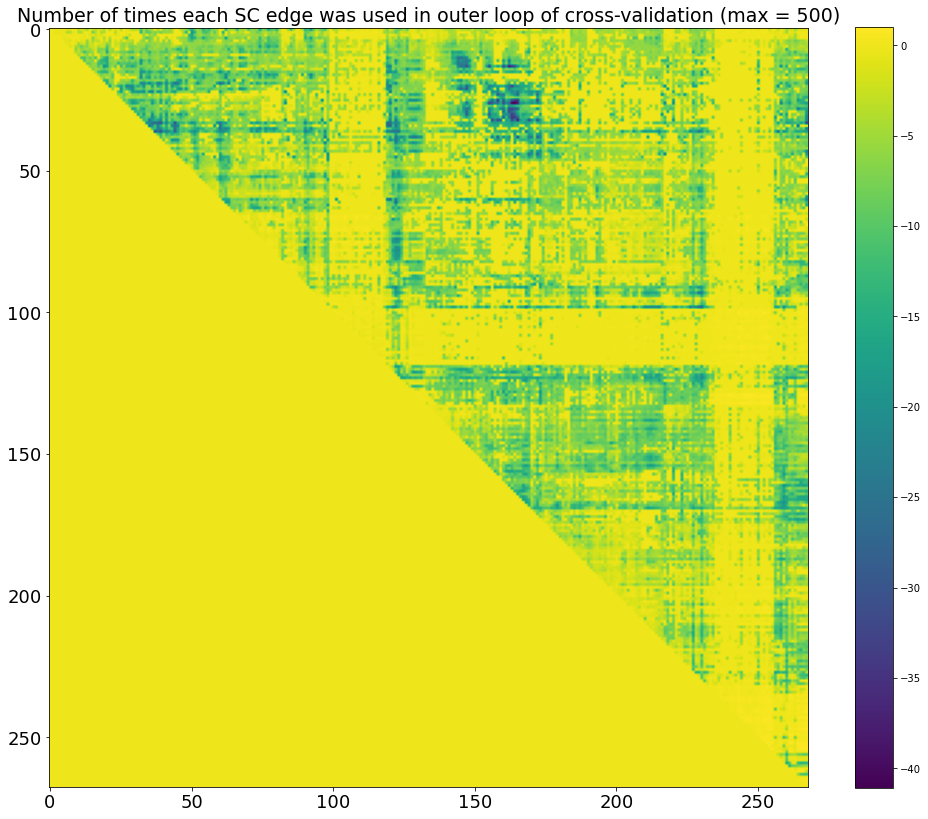

In [7]:
# convert vectorized Triu to matrix
highweights = countweights

plt.figure(figsize=(17,14))

shen268_counts = np.zeros((268, 268))
inds = np.triu_indices(268, k=1)
shen268_counts[inds] = highweights

plt.imshow(shen268_counts)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.colorbar()
plt.title('Number of times each SC edge was used in outer loop of cross-validation (max = 500)', fontsize = 19)

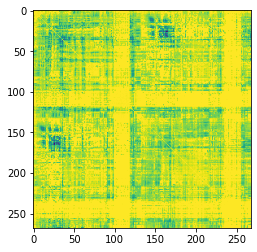

In [8]:
#make matrix symmetrical
W = np.minimum( shen268_counts, shen268_counts.transpose())
plt.imshow(W)

    

<Figure size 2160x2160 with 0 Axes>

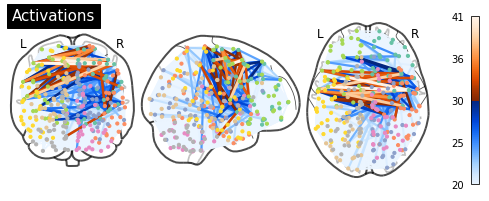

In [9]:
from nilearn import datasets
from nilearn import plotting

plt.figure(figsize=(30,30))

coordinates = plotting.find_parcellation_cut_coords('shen_2mm_268_parcellation.nii')
plotting.plot_connectome(-W, coordinates, node_size = 10,
                         title='Activations', edge_vmin=20, edge_vmax=41,alpha=0.5, edge_cmap='blue_orange',colorbar=True)

np.savetxt(results_dir +'shen268_activ_weights.txt', shen268_counts, delimiter=',')
